# Load and plot a spike raster from MATLAB data
---
_Etienne Ackermann, 07/02/2015_

### Overview
This is a demonstration of how to generate a spike raster plot either starting from Python itself, or from a MATLAB ```spikeshat``` object.

The Python data format for a spikes object is a list of ```numpy.ndarrays``` (* **NOTE!** I might legitimately change this to a standardized format, such as [neo](https://pythonhosted.org/neo/) or something similar...*)  For example,

```python
spikes = [array([ 0.0,  2.1,  4.3]),
         array([ 0.1,  4.5]),
         array([ 1.0,  2.8, 10.7, 11.0])]
```

In MATLAB, I use a cell array, with each cell containing the spike times of the associated cell. For example,

```matlab
spikeshat is a <1xNCells> cell array ---> each element is <nSpikes(cell)x1 double>

>> spikeshat

spikeshat =

Columns 1 through 3

    [10x1 double]    [3x1 double]    [297x1 double]

>> spikeshat{1} = [ 0.0;  2.1;  4.3]; ...
   spikeshat{2} = [ 0.1;  4.5]; ...
   spikeshat{3} = [ 1.0;  2.8; 10.7; 11.0];
         
```

The MATLAB cell array can then be saved as follows:

```matlab
save -v7.3 'spikefile.mat' spikeshat
```

where it is important to include the ```-v7.3``` tag, and where we need to keep track of the variable name, ```spikeshat```.

It is then a simple matter to load the ```.mat``` file into Python using the ***h5py*** module, as follows:

```python
import h5py
with h5py.File("spikefile.mat") as f:
    spikes = [f[element[0]][:] for element in f['spikeshat']]
```

> (Basically, the ```<HDF5 object reference>``` needed to be used to index the h5py file object to get the underlying array that is being referenced. After we are referring to the array that is needed, it has to be loaded to memory by indexing it with ```[:]``` or any subset if only part of the array is required. See [this stackoverflow question](http://stackoverflow.com/questions/27670149/read-matlab-v7-3-file-into-python-list-of-numpy-arrays-via-h5py).)

after which we can plot the spike raster using

```python
fig = plt.figure()
ax = raster(spikes)
plt.title('Example raster plot')
plt.xlabel('time (ms)')
plt.ylabel('cell')
```

and the ```raster``` function defined below.

#### Function definition for ```raster(spikes, color)```

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
 
def raster(ax, event_times_list, color='k'):
    """
    Creates a raster plot of spike times

    Parameters
    ----------
    ax : Axes
        The axes to draw to
    	
    event_times_list : iterable
        A list of event time iterables
        
    color : string
        Color of vlines

    Returns
    -------
    out : list
        list of artists added

    Source
    ------
    modified from https://scimusing.wordpress.com/2013/05/06/making-raster-plots-in-python-with-matplotlib/
    """
    for ith, trial in enumerate(event_times_list):
        out = ax.vlines(trial, ith + .5, ith + 1.5, color=color)
    ax.set_ylim(.5, len(event_times_list) + 0.5)
    ax.set_xlabel('time')
    ax.set_ylabel('cell')
    return out

#### Example using synthetic data generated within Python

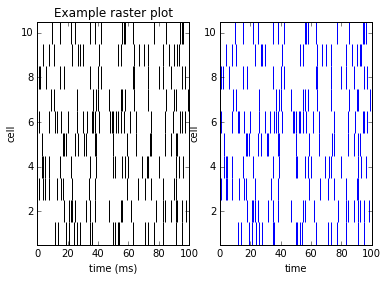

In [2]:
# example usage
# Generate test data
nbins = 100
ntrials = 10
spikes = []
for i in range(ntrials):
    spikes.append(np.arange(nbins)[np.random.rand(nbins) < .2])

# plot spike raster
fig, (ax1, ax2) = plt.subplots(1, 2)
raster(ax1, spikes)
raster(ax2, spikes,'b')
ax1.set_title('Example raster plot')
ax1.set_xlabel('time (ms)')
#fig.show()

#### Example loading data from MATLAB
(assumes data was saved as described above, namely the variable is called ```spikehat``` and was saved using the ```-v7.3``` tag to ```spikefile.mat```)

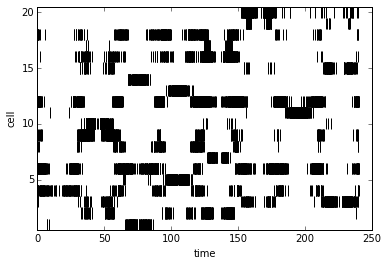

In [3]:
import h5py

# read data from .mat file
with h5py.File("../Data/spikefile.mat") as f:
    spikes = [f[element[0]][:] for element in f['spikeshat']]

# plot spike raster
fig, ax = plt.subplots(1, 1)
raster(ax, spikes)

Alternatively, we can use the ```kemerelab``` package to plot the spike raster:

kemerelab package loaded succesfully!


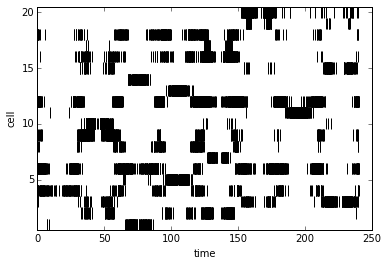

In [4]:
import os,sys
path = os.path.abspath(os.path.join(os.path.dirname('any'), '..'))
if not path in sys.path:
    sys.path.insert(1, path)
del path

import kemerelab as klab
from kemerelab.data_visualization import plot as kplot
from kemerelab.hmm import *
fig, ax = plt.subplots(1, 1)
kplot.raster(ax, spikes)

#from imp import reload
#reload(klab)

### Using the **neo** data format:

In [34]:
import neo
st = neo.SpikeTrain(spikes[1], units='sec', t_stop=250.0, unit=1)
#print(st)
#print(st.annotations)

u = neo.Unit()
u.spiketrains = st


In [39]:
import urllib.request

import numpy as np
import quantities as pq
from matplotlib import pyplot
%matplotlib inline

import neo

url = 'https://portal.g-node.org/neo/'
distantfile = url + 'neuroexplorer/File_neuroexplorer_2.nex'
localfile = 'File_neuroexplorer_2.nex'
urllib.request.urlretrieve(distantfile, localfile)


reader = neo.io.NeuroExplorerIO(filename='File_neuroexplorer_2.nex')
bl = reader.read(cascade=True, lazy=False)[0]
for seg in bl.segments:
    fig = pyplot.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    ax1.set_title(seg.file_origin)
    mint = 0 * pq.s
    maxt = np.inf * pq.s
    for i, asig in enumerate(seg.analogsignals):
        times = asig.times.rescale('s').magnitude
        asig = asig.rescale('mV').magnitude
        ax1.plot(times, asig)

    trains = [st.rescale('s').magnitude for st in seg.spiketrains]
    colors = pyplot.cm.jet(np.linspace(0, 1, len(seg.spiketrains)))
    ax2.eventplot(trains, colors=colors)

pyplot.show()

TypeError: expected bytes, bytearray or buffer compatible object

In [14]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../Styles/custom.css", "r").read()
    return HTML(styles)
css_styling()